In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


# Check device
device = torch.device('mps')
# Load a pretrained ResNet18 model
resnet18_model = models.resnet18(pretrained=True)

# Modify ResNet18 to fit MNIST (10 output classes)
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, 10)  # Change output layer for 10 classes
resnet18_model = resnet18_model.to(device)
resnet18_model.eval()


def freeze_except_last_layer(model):
    for name, param in model.named_parameters():
        # Freeze all parameters except those in the final fully connected layer
        if 'fc' not in name:
            param.requires_grad = False
        else:
            param.requires_grad = True

freeze_except_last_layer(resnet18_model)

/opt/anaconda3/envs/pyt_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/pyt_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
# Transforms for ResNet18 (3 channels)
transform_resnet18 = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize MNIST images to 224x224 for ResNet18
    transforms.Grayscale(3),        # Convert grayscale (1 channel) to RGB (3 channels)
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with MNIST mean and std
])

# Load MNIST dataset
transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
])

# Load MNIST dataset for ResNet18
train_dataset_resnet18 = datasets.MNIST(root='./data', train=True, download=True, transform=transform_resnet18)
test_dataset_resnet18 = datasets.MNIST(root='./data', train=False, download=True, transform=transform_resnet18)

# Correct dataset loading for LeNet5
train_dataset_lenet5 = datasets.MNIST(root='./data', train=True, download=True,transform=transform)
test_dataset_lenet5 = datasets.MNIST(root='./data', train=False, download=True,transform=transform)

# Ensure DataLoader consistency
train_loader_lenet5 = DataLoader(train_dataset_lenet5, batch_size=32, shuffle=True)
test_loader_lenet5 = DataLoader(test_dataset_lenet5, batch_size=32, shuffle=False)

# Data loaders for ResNet18
train_loader_resnet18 = DataLoader(train_dataset_resnet18, batch_size=32, shuffle=True)
test_loader_resnet18 = DataLoader(test_dataset_resnet18, batch_size=32, shuffle=False)


In [5]:
# Plot image grid
def plot_image_grid(num_row, num_col, images, labels, image_shape):
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
    for i in range(num_row * num_col):
        ax = axes[i // num_col, i % num_col]
        ax.imshow(images[i].reshape(image_shape), cmap='gray')
        ax.set_title('Label: {}'.format(labels[i]))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

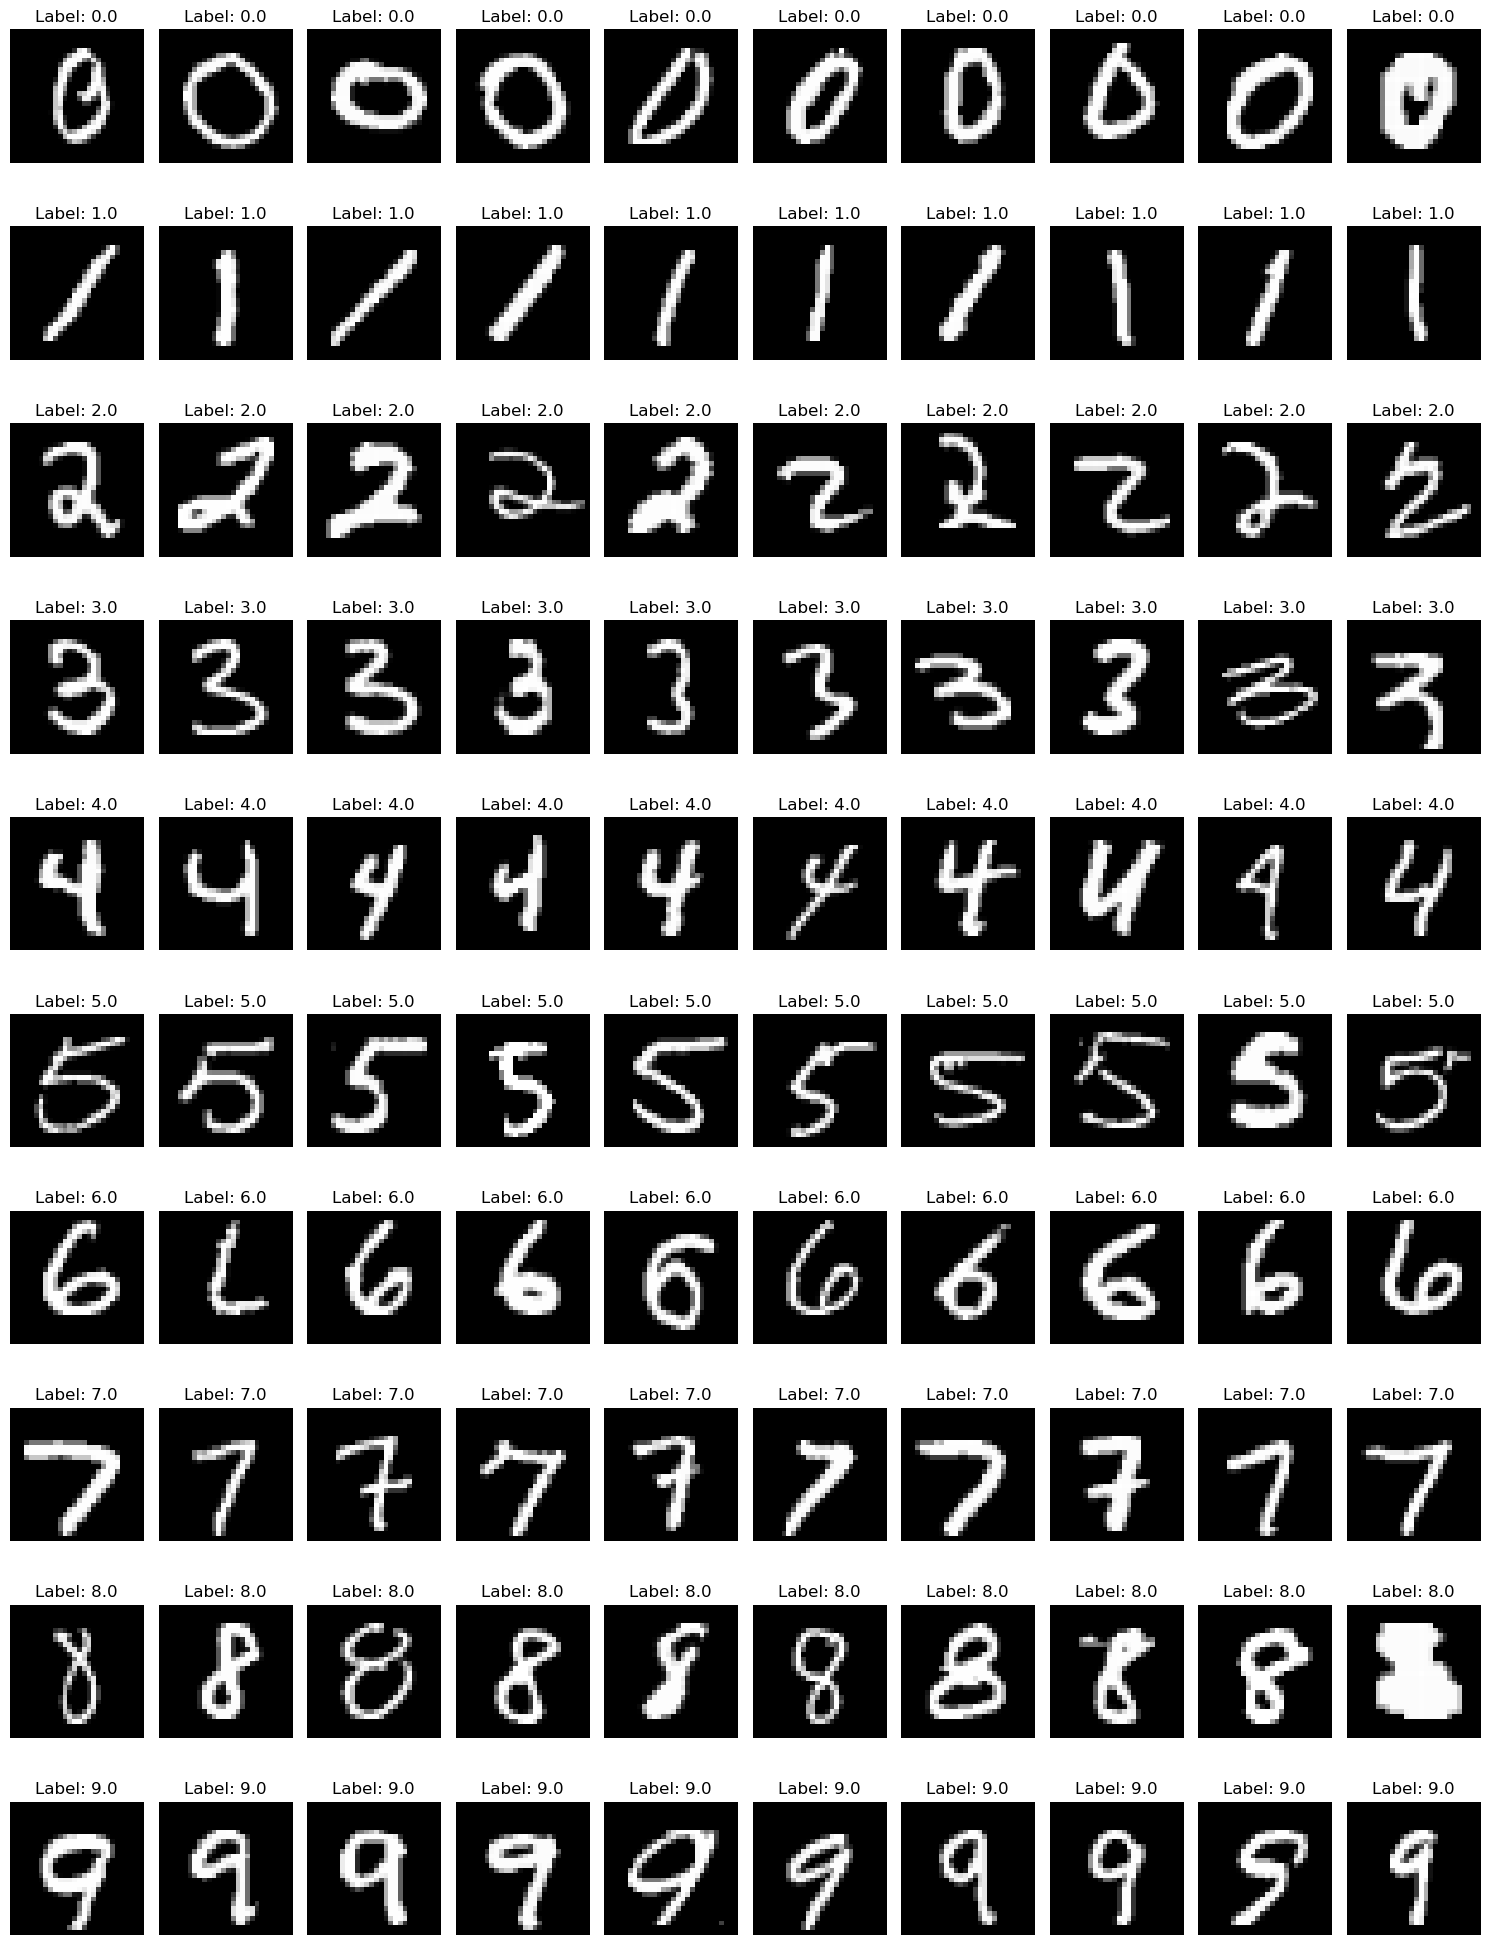

In [13]:
nb_classes = 10
samples_per_class = 10
total_samples = nb_classes * samples_per_class
image_samples = np.zeros((total_samples, 28, 28, 1))
label_samples = np.zeros((total_samples,))
rng = np.random.default_rng()

# Fill image and label samples
filled_samples = {i: 0 for i in range(nb_classes)}  # Track samples for each class
for images, labels in train_loader_lenet5:
    images = images.numpy()
    labels = labels.numpy()
    
    for i in range(nb_classes):
        indices = np.where(labels == i)[0]
        rng.shuffle(indices)
        
        # Number of samples needed to complete 10 for each class
        samples_needed = samples_per_class - filled_samples[i]
        num_selected = min(samples_needed, len(indices))
        selected_indices = indices[:num_selected]
        
        start_idx = i * samples_per_class + filled_samples[i]
        image_samples[start_idx:start_idx + num_selected, ...] = images[selected_indices].transpose(0, 2, 3, 1)
        label_samples[start_idx:start_idx + num_selected] = i
        filled_samples[i] += num_selected  # Update filled count
        
    # Check if all classes are filled
    if all(count >= samples_per_class for count in filled_samples.values()):
        break

# Plot to verify display
plot_image_grid(nb_classes, samples_per_class, image_samples, label_samples, (28, 28))


In [19]:
# Define LeNet in PyTorch
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 7 * 7, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [20]:

# Initialize LeNet5 model
lenet5_model = LeNet().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_resnet18 = optim.Adam(resnet18_model.parameters(), lr=0.001)
optimizer_lenet5 = optim.Adam(lenet5_model.parameters(), lr=0.001)


In [17]:
# Function to evaluate the model accuracy
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Function to train a model
def train_model(model, optimizer, train_loader, test_loader, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Debugging batch sizes
            # print(f'Batch size - outputs: {outputs.size(0)}, labels: {labels.size(0)}')

            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Evaluate accuracy on test set
        test_accuracy = evaluate(model, test_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


In [18]:
# Training ResNet18 on MNIST
print("Training ResNet18 on MNIST:")
train_model(resnet18_model, optimizer_resnet18, train_loader_resnet18, test_loader_resnet18, num_epochs=5)

Training ResNet18 on MNIST:
Epoch [1/5], Loss: 626.5004, Test Accuracy: 95.61%
Epoch [2/5], Loss: 307.7486, Test Accuracy: 96.05%
Epoch [3/5], Loss: 267.4015, Test Accuracy: 95.80%
Epoch [4/5], Loss: 244.7260, Test Accuracy: 96.35%
Epoch [5/5], Loss: 235.4616, Test Accuracy: 96.41%


In [42]:
# Training LeNet5 on MNIST
print("\nTraining LeNet5 on MNIST:")
train_model(lenet5_model, optimizer_lenet5, train_loader_lenet5,test_loader_lenet5, num_epochs=5)


Training LeNet5 on MNIST:
Epoch [1/5], Loss: 614.5067, Test Accuracy: 96.16%
Epoch [2/5], Loss: 174.3232, Test Accuracy: 97.99%
Epoch [3/5], Loss: 125.9088, Test Accuracy: 98.22%
Epoch [4/5], Loss: 99.7127, Test Accuracy: 98.61%
Epoch [5/5], Loss: 84.3267, Test Accuracy: 98.76%


In [15]:
def pgd_attack(model, input_image, input_label=None,
               epsilon=0.3,
               num_steps=20,
               step_size=0.01,
               clip_value_min=0.,
               clip_value_max=1.0):

    if type(input_image) is np.ndarray:
        input_image = torch.tensor(input_image, requires_grad=True)

    if type(input_label) is np.ndarray:
        input_label = torch.tensor(input_label)

    # Ensure the model is in evaluation mode
    model.eval()

    # Create a copy of the input image and set it to require gradients
    adv_image = input_image.clone().detach().requires_grad_(True)  # Ensure requires_grad is True

    # Random initialization around input_image
    random_noise = torch.FloatTensor(input_image.shape).uniform_(-epsilon, epsilon).to(device)
    adv_image = adv_image + random_noise
    adv_image = torch.clamp(adv_image, clip_value_min, clip_value_max).detach().requires_grad_(True)

    # If no input label is provided, use the model's prediction
    if input_label is None:
        output = model(input_image)
        input_label = torch.argmax(output, dim=1)

    # Perform PGD attack
    for _ in range(num_steps):
        adv_image.requires_grad_(True)  # Ensure requires_grad is True in each iteration
        output = model(adv_image)
        loss = nn.CrossEntropyLoss()(output, input_label)
        model.zero_grad()
        loss.backward()

        # Check if gradient is available before accessing 'data'
        if adv_image.grad is not None:
            gradient = adv_image.grad.data
            adv_image = adv_image + step_size * gradient.sign()
            adv_image = torch.clamp(adv_image, input_image - epsilon, input_image + epsilon)  # Clip to a valid boundary
            adv_image = torch.clamp(adv_image, clip_value_min, clip_value_max)  # Clip to a valid range
            adv_image = adv_image.detach()  # Detach to prevent gradient accumulation
        else:
            print("Warning: Gradient is None. Check for detach operations.")

    return adv_image.detach()

In [16]:
def fgsm_attack(model, input_image, input_label=None,
                epsilon=0.3,
                clip_value_min=0.,
                clip_value_max=1.0):
    """
    Args:
        model: pretrained model
        input_image: original (clean) input image (tensor)
        input_label: original label (tensor, categorical representation)
        epsilon: perturbation boundary
        clip_value_min, clip_value_max: range of valid input
    Note:
        we expect the output of model should be logits vector
    """

    if type(input_image) is np.ndarray:
        input_image = torch.tensor(input_image, requires_grad=True)

    if type(input_label) is np.ndarray:
        input_label = torch.tensor(input_label)

    # Ensure the model is in evaluation mode
    model.eval()

    # Create a copy of the input image and set it to require gradients
    adv_image = input_image.clone().detach().requires_grad_(True)  # Ensure requires_grad is True

    # Random initialization around input_image
    random_noise = torch.FloatTensor(input_image.shape).uniform_(-epsilon, epsilon).to(device)
    adv_image = adv_image + random_noise
    adv_image = torch.clamp(adv_image, clip_value_min, clip_value_max).detach().requires_grad_(True)

    output = model(adv_image)

    if input_label is not None:
        loss = F.cross_entropy(output, input_label)  # use ground-truth label to attack
    else:
        pred_label = output.argmax(dim=1)  # use predicted label to attack
        loss = F.cross_entropy(output, pred_label)

    model.zero_grad()
    loss.backward()

    # Use the gradient of adv_image instead of input_image
    gradient = adv_image.grad.data
    adv_image = adv_image + epsilon * gradient.sign()
    adv_image = torch.clamp(adv_image, clip_value_min, clip_value_max)

    return adv_image.detach()

In [17]:
def attack(attack_type, model, input_image,
            input_label=None,
            epsilon=0.3,
            num_steps=20,
            step_size=0.01,
            clip_value_min=0.,
            clip_value_max=1.0):

    if attack_type == 'fgsm':
        return fgsm_attack(model=model,
                        input_image=input_image,
                        input_label=input_label,
                        epsilon=epsilon,
                        clip_value_min=clip_value_min,
                        clip_value_max=clip_value_max)
    else:
        return pgd_attack(model=model,
                        input_image=input_image,
                        input_label=input_label,
                        epsilon=epsilon,
                        num_steps=num_steps,
                        step_size=step_size,
                        clip_value_min=clip_value_min,
                        clip_value_max=clip_value_max)

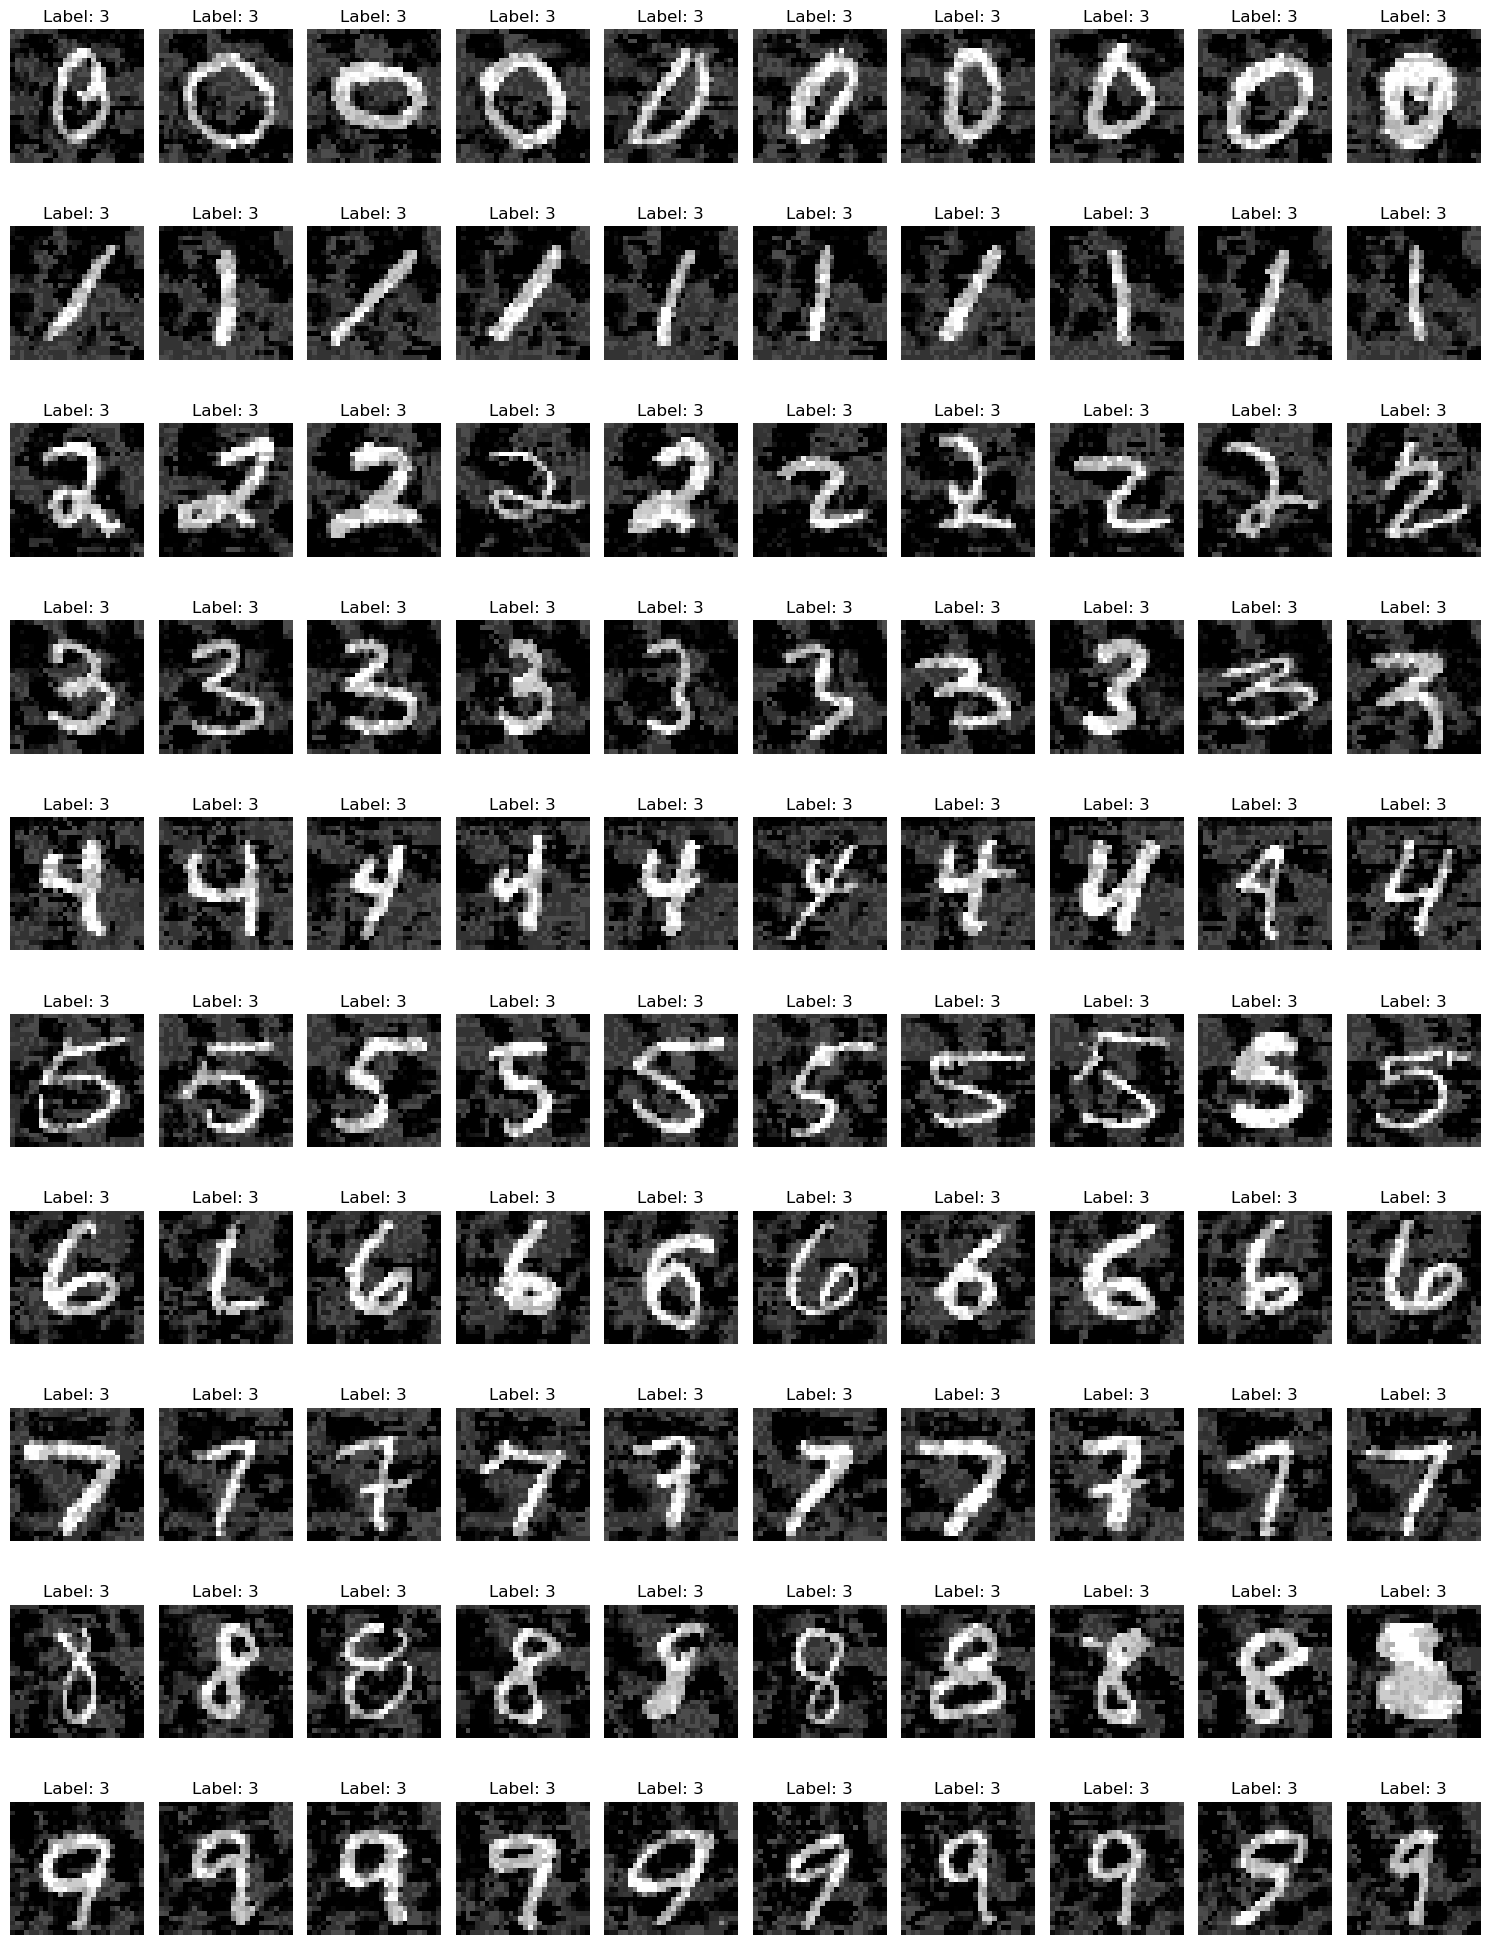

In [21]:
# Generate adversarial examples for the image samples
image_samples_tensor = torch.tensor(image_samples).permute(0, 3, 1, 2).float().to(device)
label_samples_tensor = torch.tensor(label_samples).long().to(device)

image_samples_adv = pgd_attack(lenet5_model, image_samples_tensor, label_samples_tensor, epsilon=0.3,
                               num_steps=20, step_size=0.01, clip_value_min=0.0, clip_value_max=1.0)
image_samples_adv_np = image_samples_adv.permute(0, 2, 3, 1).detach().cpu().numpy()
label_sample_adv = np.argmax(lenet5_model(image_samples_adv).detach().cpu().numpy(), axis=1)
# Plot the adversarial image grid
plot_image_grid(nb_classes, samples_per_class, image_samples_adv_np, label_sample_adv, (28, 28))


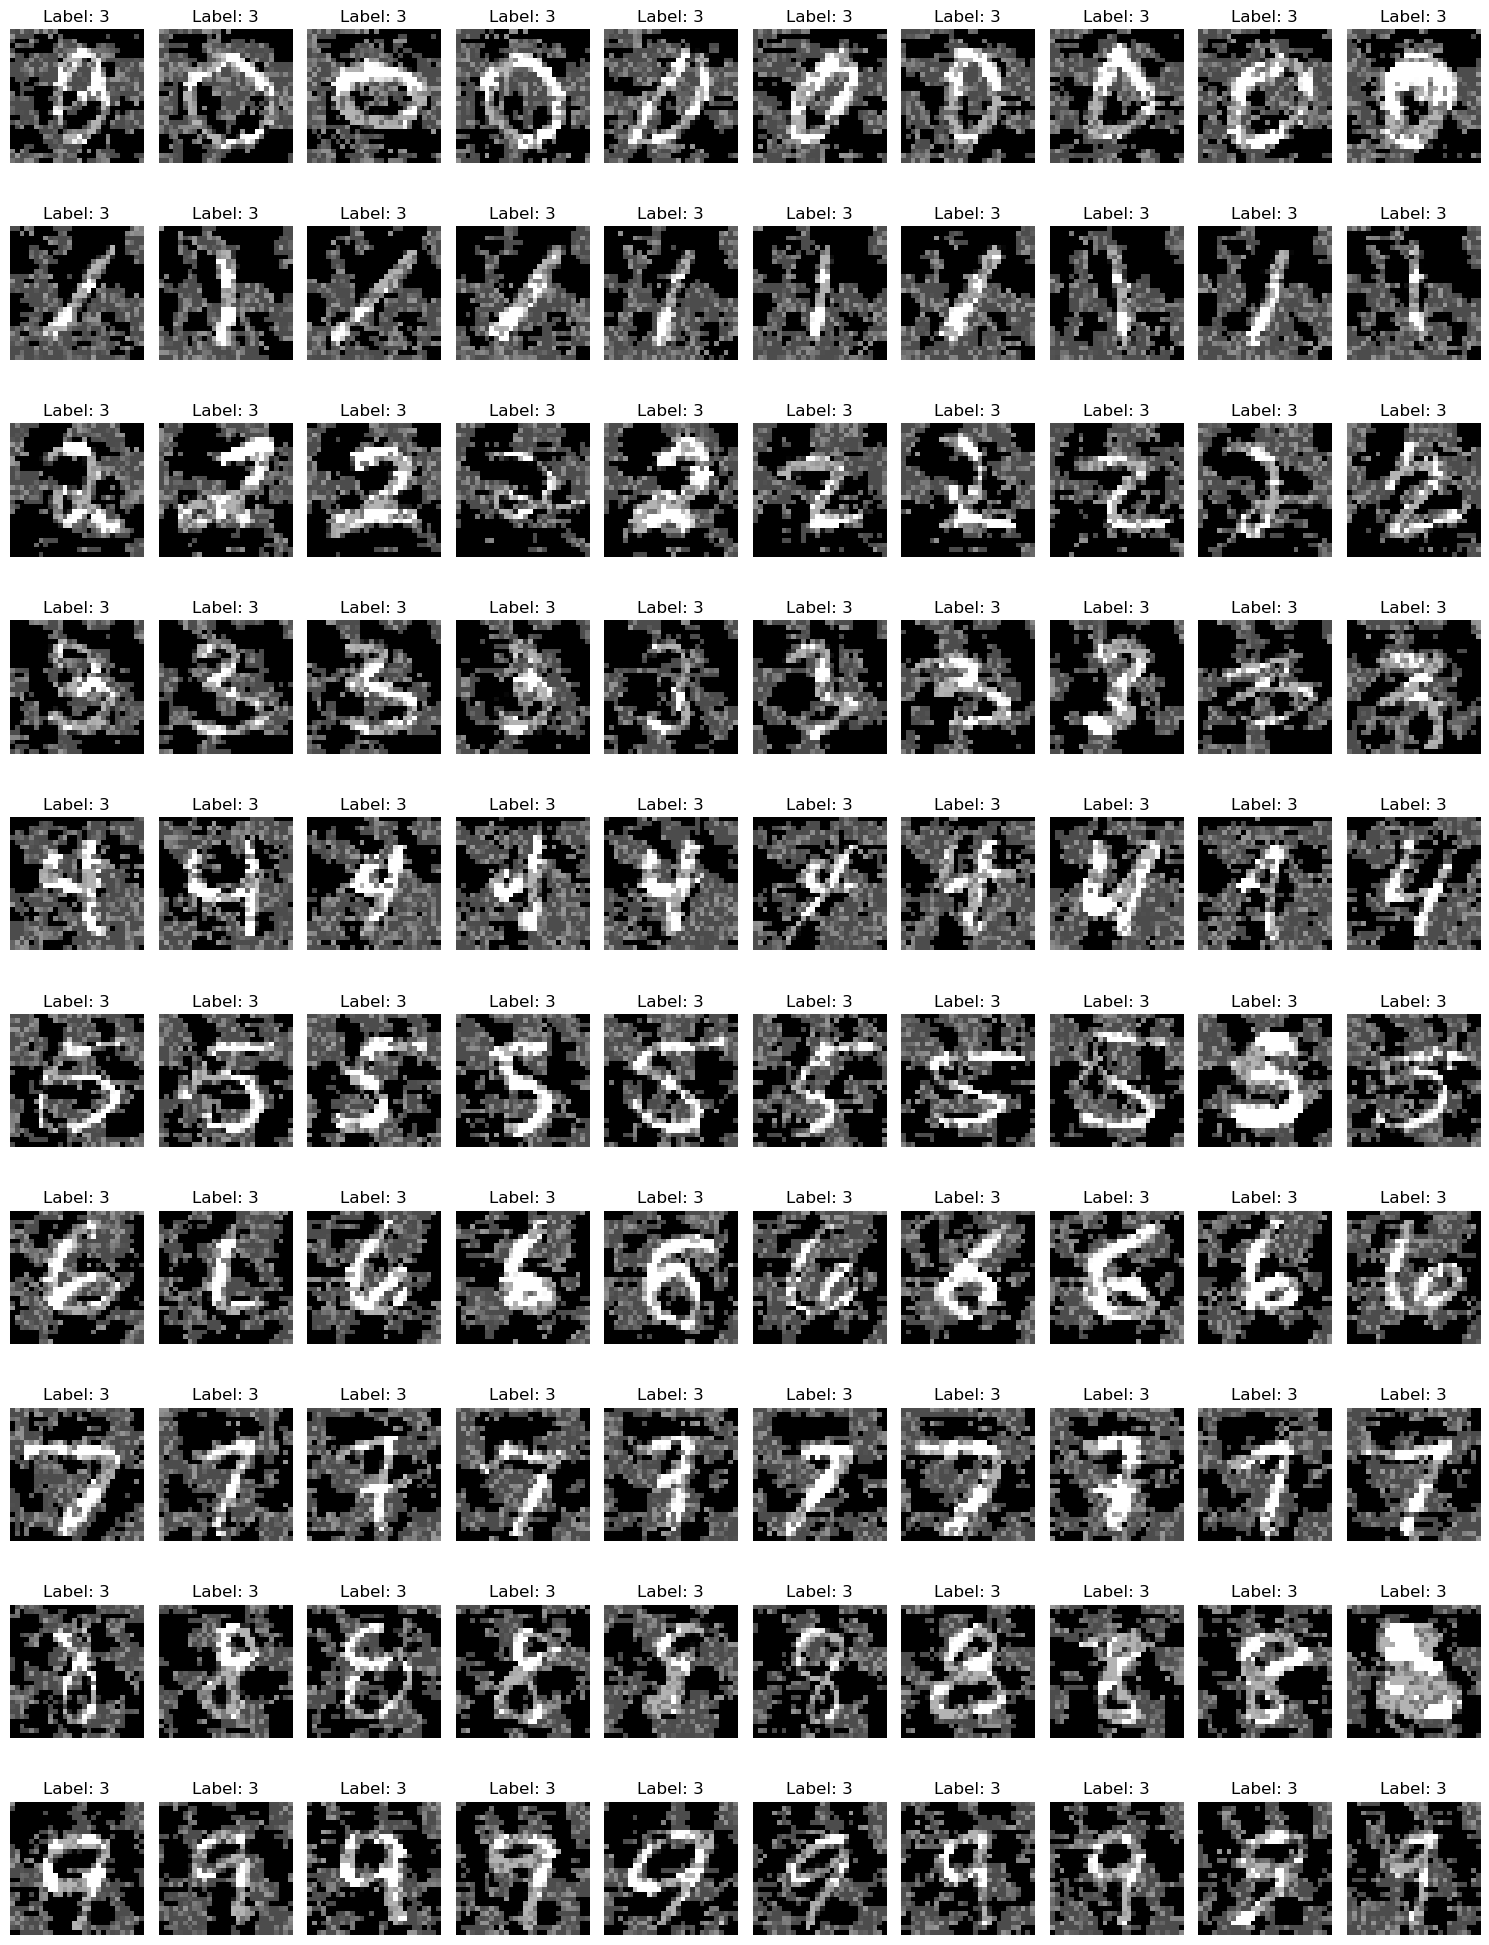

In [24]:
# Generate adversarial examples for the image samples
image_samples_tensor = torch.tensor(image_samples).permute(0, 3, 1, 2).float().to(device)
label_samples_tensor = torch.tensor(label_samples).long().to(device)

image_samples_adv = fgsm_attack(lenet5_model, image_samples_tensor, label_samples_tensor, epsilon=0.3,clip_value_min=0.0, clip_value_max=1.0)
image_samples_adv_np = image_samples_adv.permute(0, 2, 3, 1).detach().cpu().numpy()
label_sample_adv = np.argmax(lenet5_model(image_samples_adv).detach().cpu().numpy(), axis=1)
# Plot the adversarial image grid
plot_image_grid(nb_classes, samples_per_class, image_samples_adv_np, label_sample_adv, (28, 28))

In [117]:
def calculate_attack_success_rate(model, data_loader, attack_type="pgd"):
    model.eval()
    successful_attacks = 0
    total = 0
    for data, target in data_loader:
        data, target = data.to(device), target.to(device)

        adv_data = attack(attack_type,model, data, target, epsilon=0.3, num_steps=10, step_size=0.01,
                          clip_value_min=0.0, clip_value_max=1.0)
        
        output = model(adv_data)
        _, predicted = torch.max(output, 1)

        successful_attacks += (predicted != target).sum().item()
        total += target.size(0)

    attack_success_rate = 100 * successful_attacks / total
    return attack_success_rate


In [121]:
print("Evaluating PGD attack success rate for ResNet18resnet18_model...")
resnet18_model_asr = calculate_attack_success_rate(resnet18_model, test_loader_resnet18,attack_type="pgd_attack")
print(f"PGD Attack Success Rate for ResNet50: {resnet18_model_asr:.2f}%")

Evaluating PGD attack success rate for ResNet18resnet18_model...
PGD Attack Success Rate for ResNet50: 100.00%


In [122]:
print("Evaluating PGD attack success rate for LeNet...")
lenet_asr = calculate_attack_success_rate(lenet5_model, test_loader_lenet5,attack_type="pgd_attack")
print(f"PGD Attack Success Rate for LeNet: {lenet_asr:.2f}%")

Evaluating PGD attack success rate for LeNet...
PGD Attack Success Rate for LeNet: 99.79%


In [123]:
print("Evaluating FGSM attack success rate for ResNet18resnet18_model...")
resnet18_model_asr = calculate_attack_success_rate(resnet18_model, test_loader_resnet18,attack_type="fgsm")
print(f"FGSM Attack Success Rate for ResNet50: {resnet18_model_asr:.2f}%")

Evaluating FGSM attack success rate for ResNet18resnet18_model...
FGSM Attack Success Rate for ResNet50: 89.79%


In [124]:
print("Evaluating  FGSM Lenet attack success rate for LeNet...")
lenet_asr = calculate_attack_success_rate(lenet5_model, train_loader_lenet5,attack_type="fgsm")
print(f"FGSM Attack Success Rate for LeNet: {lenet_asr:.2f}%")

Evaluating  FGSM Lenet attack success rate for LeNet...
FGSM Attack Success Rate for LeNet: 99.95%


In [ ]:
# Initialize model, optimizer, and loss function
criterion = nn.CrossEntropyLoss()

lenet_defence = LeNet().to(device)
optimizer_lenet_defence = optim.Adam(lenet_defence.parameters(), lr=0.001)


In [102]:
resnet18_model_defence = models.resnet18()

# Modify ResNet18 to fit MNIST (10 output classes)
resnet18_model_defence.fc = nn.Linear(resnet18_model_defence.fc.in_features, 10)  # Change output layer for 10 classes
resnet18_model_defence = resnet18_model_defence.to(device)

optimizer_resnet18_defence = optim.Adam(resnet18_model_defence.parameters(), lr=0.001)

In [60]:
# Training function with adversarial examples
def train_step_adv(model, x, x_adv, y, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    logits = model(x)
    logits_adv = model(x_adv)
    loss = (criterion(logits, y) + criterion(logits_adv, y)) / 2
    loss.backward()
    optimizer.step()

    pred_adv = logits_adv.argmax(dim=1, keepdim=True)
    return loss.item(), pred_adv

# Metrics
train_loss = []
test_acc_clean = []
test_acc_pgd = []


In [111]:
epochs = 5
from sklearn.metrics import accuracy_score

def adverserial_training(attack,train_loader,model,optimizer,criterion):
    for epoch in range(epochs):
        lenet_defence.train()
        total_loss = 0.0
        y_pred = []
        y_true = []
        for batch_idx, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            x_adv = attack(model, x, y, epsilon=0.3, num_steps=10, step_size=0.01, clip_value_min=0.0, clip_value_max=1.0)
            loss, pred_adv= train_step_adv(model, x, x_adv, y, optimizer, criterion)

            # Log
            total_loss += loss
            y_pred.extend(pred_adv.squeeze().cpu().numpy())
            y_true.extend(y.cpu().numpy())
        train_loss = total_loss / len(train_loader)
        train_acc = accuracy_score(y_true, y_pred)

        print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Training Acc: {train_acc*100:.2f}%, ")

In [112]:
adverserial_training(pgd_attack,train_loader_resnet18,resnet18_model_defence,optimizer_resnet18_defence,criterion)

Epoch 1, Training Loss: 0.0461, Training Acc: 98.35%, 
Epoch 2, Training Loss: 0.0378, Training Acc: 98.50%, 
Epoch 3, Training Loss: 0.0296, Training Acc: 98.94%, 
Epoch 4, Training Loss: 0.0233, Training Acc: 99.22%, 
Epoch 5, Training Loss: 0.0153, Training Acc: 99.58%, 


In [64]:
adverserial_training(pgd_attack,train_loader_lenet5,lenet_defence,optimizer_lenet_defence,criterion)

Epoch 1, Training Loss: 0.5743, Training Acc: 72.12%, 
Epoch 2, Training Loss: 0.2134, Training Acc: 89.18%, 
Epoch 3, Training Loss: 0.1593, Training Acc: 91.76%, 
Epoch 4, Training Loss: 0.1317, Training Acc: 93.13%, 
Epoch 5, Training Loss: 0.1136, Training Acc: 93.88%, 


In [125]:
print("Evaluating attack success rate for Adversarial trained ResNet18resnet18_model...")
resnet18_model_asr = calculate_attack_success_rate(resnet18_model_defence, test_loader_resnet18, attack_type="pgd")
print(f"PGD Attack Success Rate for Adversarial trained ResNet50: {resnet18_model_asr:.2f}%")

Evaluating attack success rate for Adversarial trained ResNet18resnet18_model...
PGD Attack Success Rate for Adversarial trained ResNet50: 74.98%


In [126]:
print("Evaluating attack success rate for Adversarial trained LeNet...")
lenet_asr = calculate_attack_success_rate(lenet_defence, test_loader_lenet5, attack_type="pgd")
print(f"PGD Attack Success Rate for Adversarial trained LeNet: {lenet_asr:.2f}%")

Evaluating attack success rate for Adversarial trained LeNet...
PGD Attack Success Rate for Adversarial trained LeNet: 16.46%


In [127]:
print("Evaluating FGSM attack success rate for ResNet18resnet18_model...")
resnet18_model_asr = calculate_attack_success_rate(resnet18_model_defence, test_loader_resnet18,attack_type="fgsm")
print(f"FGSM Attack Success Rate for ResNet50: {resnet18_model_asr:.2f}%")

Evaluating FGSM attack success rate for ResNet18resnet18_model...
FGSM Attack Success Rate for ResNet50: 99.55%


In [128]:
print("Evaluating  FGSM Lenet attack success rate for LeNet...")
lenet_asr = calculate_attack_success_rate(lenet_defence, train_loader_lenet5,attack_type="fgsm")
print(f"FGSM Attack Success Rate for LeNet: {lenet_asr:.2f}%")

Evaluating  FGSM Lenet attack success rate for LeNet...
FGSM Attack Success Rate for LeNet: 65.72%


In [120]:
import torch
import os

def save_custom_models(models_to_save, save_dir="saved_custom_models"):
    """
    Save custom PyTorch models to a specified folder.

    Args:
        models_to_save (dict): Dictionary with model names as keys and model instances as values.
                               e.g., {"my_model1": model1, "my_model2": model2}
        save_dir (str): Path to the directory where models will be saved.
    """
    # Create the save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    for model_name, model in models_to_save.items():
        # Ensure model is in evaluation mode
        model.eval()
        
        # Define model save path
        model_path = os.path.join(save_dir, f"{model_name}.pth")
        
        # Save the model's state dictionary
        torch.save(model.state_dict(), model_path)
        print(f"Model '{model_name}' saved to '{model_path}'.")

# Example usage
# Assume model1, model2 are instances of your custom PyTorch models
models_to_save = {
    "resnet_18_defence": resnet18_model_defence
    # Add more models as needed
}
save_custom_models(models_to_save, save_dir="my_custom_model_folder")


Model 'resnet_18_defence' saved to 'my_custom_model_folder/resnet_18_defence.pth'.
